# This is messed up

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns

import imblearn

from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report


import xgboost as xgb

In [2]:
### download the db from link in readme
db_path = "../../dbs/delays.db"

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [4]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = (df.ArrDelay>15).astype(int)
    
    df = df.drop('ArrDelay', axis=1)
    
    # One-hot encode nominal feature columns
    X = onehot_encode(
        df,
        column_dict={
            'IATA_CODE_Reporting_Airline': 'AL',
            'OriginAirportID': 'OA',
            'DestAirportID': 'DA',
            'Month': 'M',
            'DayofMonth': 'DM',
            'DayOfWeek': 'DW',
   
        }
    )
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    
    # Todo: only apply this to columns that need it    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
   
    return X_train, X_test, y_train, y_test

In [6]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [7]:
sample_query = \
    """
    with delayed as(
        select 
         Month,
         DayofMonth,
         DayOfWeek,
         SUBSTR(CRSDepTime, 1,LENGTH(CRSDepTime)-2) as DepHour,
         
         IATA_CODE_Reporting_Airline,
         OriginAirportID,
         DestAirportID,
         AirTime,
         DepDelay,
         ArrDelay
        from 
          delay
        where ArrDelay>15
        and ArrDelay<300
        and Cancelled = 0
        and Year = 2015
        order by RANDOM() LIMIT 100000),
        
    not_delayed as(
       select 
         Month,
         DayofMonth,
         DayOfWeek,
         SUBSTR(CRSDepTime, 1,LENGTH(CRSDepTime)-2) as DepHour,
        
         IATA_CODE_Reporting_Airline,
         OriginAirportID,
         DestAirportID,
         AirTime,
         DepDelay,
         ArrDelay
        from 
          delay
        where ArrDelay<=15
        and Cancelled = 0
        and Year = 2015
        order by RANDOM() LIMIT 100000)
        
    select * from delayed union select * from not_delayed
    
    """

connection = create_connection(db_path)
# data =  execute_query(connection, sample_query)

In [8]:
Flights = pd.read_csv('../../datasets/flights.csv')

/Users/ayushsubedi/Desktop/learn/fp/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
Flights

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,...,753.0,-26.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819075,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,...,430.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819076,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,...,432.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819077,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,...,330.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
Flights = Flights.iloc[:,:23]
Flights.dropna(inplace=True)
Flights = Flights[Flights["MONTH"]==1]
Flights.reset_index(inplace=True)

In [11]:
list(Flights)

['index',
 'YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY']

In [12]:
data = Flights.copy()

In [13]:
data.rename({
     'YEAR': 'Year',
     'MONTH': 'Month',
     'AIRLINE' : 'IATA_CODE_Reporting_Airline',
     'DAY': 'DayofMonth',
     'DAY_OF_WEEK': 'DayOfWeek',
     'ORIGIN_AIRPORT': 'OriginAirportID',
     'DESTINATION_AIRPORT': 'DestAirportID',
     'DEPARTURE_DELAY' : 'DepDelay',
     'AIR_TIME': 'AirTime',
     'ARRIVAL_DELAY' : 'ArrDelay'
}, axis=1
, inplace=True)

In [14]:
cols = ['Month',
 'DayofMonth',
 'DayOfWeek',
 'IATA_CODE_Reporting_Airline',
 'OriginAirportID',
 'DestAirportID',
 'AirTime',
 'ArrDelay']

In [15]:
X_train, X_test, y_train, y_test = preprocess_inputs(data[cols])

In [16]:
X_train

,AirTime,AL_AA,AL_AS,AL_B6,AL_DL,AL_EV,AL_F9,AL_HA,AL_MQ,AL_NK,...,DM_29,DM_30,DM_31,DW_1,DW_2,DW_3,DW_4,DW_5,DW_6,DW_7
0,-0.901085,-0.322188,-0.171853,-0.216696,-0.402192,-0.342129,-0.122185,-0.119129,-0.25367,-0.139316,...,-0.188957,-0.19025,-0.162898,-0.393828,-0.378195,-0.39167,-0.447359,-0.460851,-0.399577,2.610367
1,-1.054703,-0.322188,-0.171853,-0.216696,-0.402192,-0.342129,-0.122185,-0.119129,-0.25367,-0.139316,...,-0.188957,-0.19025,-0.162898,-0.393828,2.644140,-0.39167,-0.447359,-0.460851,-0.399577,-0.383088
2,1.919901,-0.322188,-0.171853,-0.216696,-0.402192,-0.342129,-0.122185,-0.119129,-0.25367,-0.139316,...,-0.188957,-0.19025,-0.162898,-0.393828,-0.378195,-0.39167,2.235342,-0.460851,-0.399577,-0.383088
3,0.118380,-0.322188,-0.171853,-0.216696,2.486375,-0.342129,-0.122185,-0.119129,-0.25367,-0.139316,...,-0.188957,-0.19025,-0.162898,-0.393828,-0.378195,-0.39167,-0.447359,-0.460851,-0.399577,2.610367
4,-0.607814,-0.322188,-0.171853,-0.216696,2.486375,-0.342129,-0.122185,-0.119129,-0.25367,-0.139316,...,-0.188957,-0.19025,-0.162898,-0.393828,-0.378195,-0.39167,-0.447359,-0.460851,-0.399577,2.610367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365605,-0.747467,3.103780,-0.171853,-0.216696,-0.402192,-0.342129,-0.122185,-0.119129,-0.25367,-0.139316,...,-0.188957,-0.19025,-0.162898,-0.393828,-0.378195,-0.39167,-0.447359,-0.460851,-0.399577,2.610367
365606,-0.705571,-0.322188,-0.171853,-0.216696,-0.402192,-0.342129,-0.122185,-0.119129,-0.25367,-0.139316,...,-0.188957,-0.19025,-0.162898,-0.393828,-0.378195,-0.39167,-0.447359,-0.460851,-0.399577,2.610367
365607,-0.761432,-0.322188,-0.171853,-0.216696,-0.402192,2.922877,-0.122185,-0.119129,-0.25367,-0.139316,...,-0.188957,-0.19025,-0.162898,-0.393828,-0.378195,-0.39167,-0.447359,2.169900,-0.399577,-0.383088
365608,0.495443,-0.322188,-0.171853,-0.216696,2.486375,-0.342129,-0.122185,-0.119129,-0.25367,-0.139316,...,-0.188957,-0.19025,-0.162898,-0.393828,-0.378195,-0.39167,-0.447359,-0.460851,2.502648,-0.383088


In [17]:
clf_rf = RandomForestClassifier(n_estimators = 100, verbose=1, n_jobs=-1) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf_rf.fit(X_train, y_train)
 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.5s finished


Test Accuracy: 77.13%


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


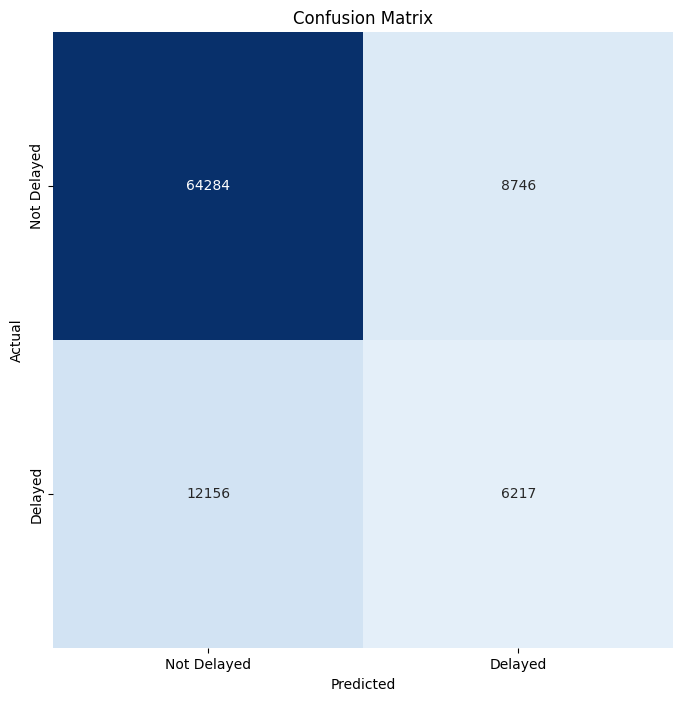

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.84      0.88      0.86     73030
     Delayed       0.42      0.34      0.37     18373

    accuracy                           0.77     91403
   macro avg       0.63      0.61      0.62     91403
weighted avg       0.76      0.77      0.76     91403



In [18]:
evaluate_model(clf_rf, X_test, y_test)

Test Accuracy: 81.72%


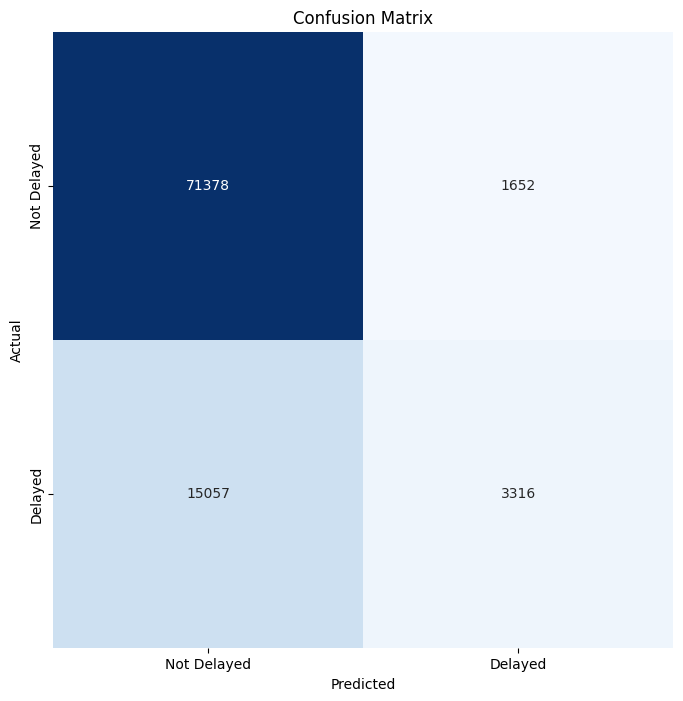

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.83      0.98      0.90     73030
     Delayed       0.67      0.18      0.28     18373

    accuracy                           0.82     91403
   macro avg       0.75      0.58      0.59     91403
weighted avg       0.79      0.82      0.77     91403



In [19]:
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train, y_train)

evaluate_model(xgb_cl, X_test, y_test)